In [ ]:
import pandas as pd
import numpy as np

# Load the dataset (example using NASA GISTEMP)
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
data = pd.read_csv(url, skiprows=1)

# Preprocessing
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data.set_index('Year', inplace=True)
data = data[['J-D']]  # Using annual mean temperature anomalies
data.columns = ['Temperature Anomaly']

# Replace non-numeric values with NaN and then forward fill them
data['Temperature Anomaly'] = pd.to_numeric(data['Temperature Anomaly'], errors='coerce')
data.fillna(method='ffill', inplace=True)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['Temperature Anomaly'] = scaler.fit_transform(data[['Temperature Anomaly']])

data.head()


,Temperature Anomaly
Year,
1880-01-01,0.187879
1881-01-01,0.236364
1882-01-01,0.224242
1883-01-01,0.181818
1884-01-01,0.115152


from matplotlib import pyplot as plt
_df_0['Temperature Anomaly'].plot(kind='hist', bins=20, title='Temperature Anomaly')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Temperature Anomaly'].plot(kind='line', figsize=(8, 4), title='Temperature Anomaly')
plt.gca().spines[['top', 'right']].set_visible(False)

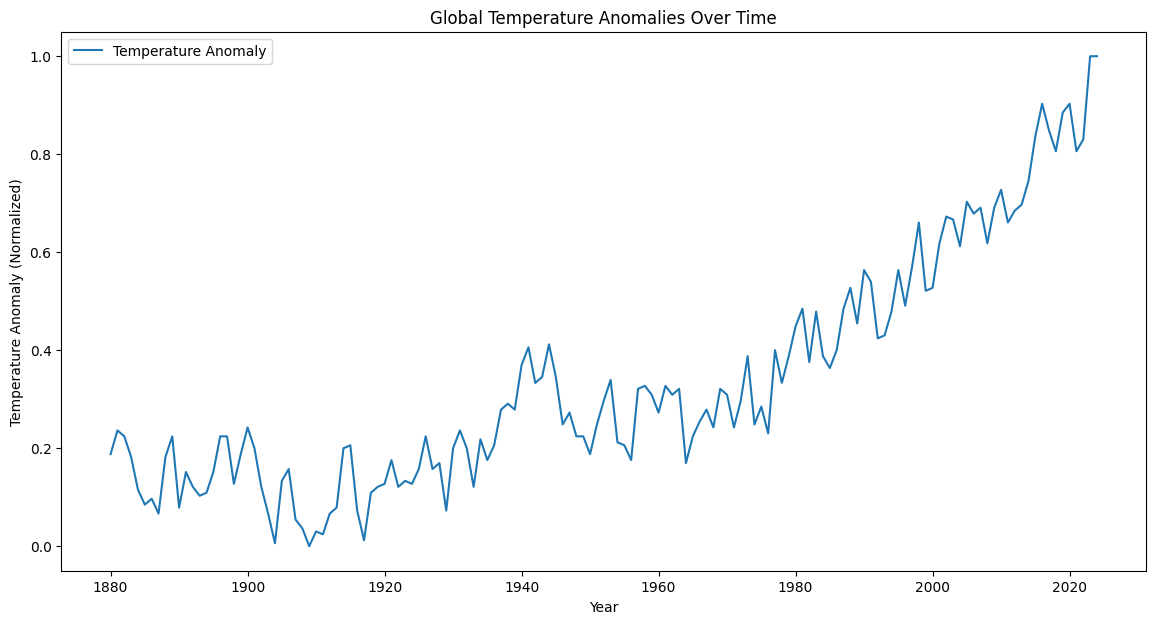

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series plot of temperature anomalies
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Temperature Anomaly'], label='Temperature Anomaly')
plt.title('Global Temperature Anomalies Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (Normalized)')
plt.legend()
plt.show()


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Convert the dataframe to numpy array
data_array = data.values

# Define time step
time_step = 10

X, Y = create_dataset(data_array, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, verbose=1)


Epoch 1/100
4/4 [==============================] - 11s 303ms/step - loss: 0.1601 - val_loss: 0.0599
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0781 - val_loss: 0.0201
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0199 - val_loss: 0.0208
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0229 - val_loss: 0.0332
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0211 - val_loss: 0.0132
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 8/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0123 - val_loss: 0.0081
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 11/100
4/4 

1/1 [==============================] - 0s 101ms/step


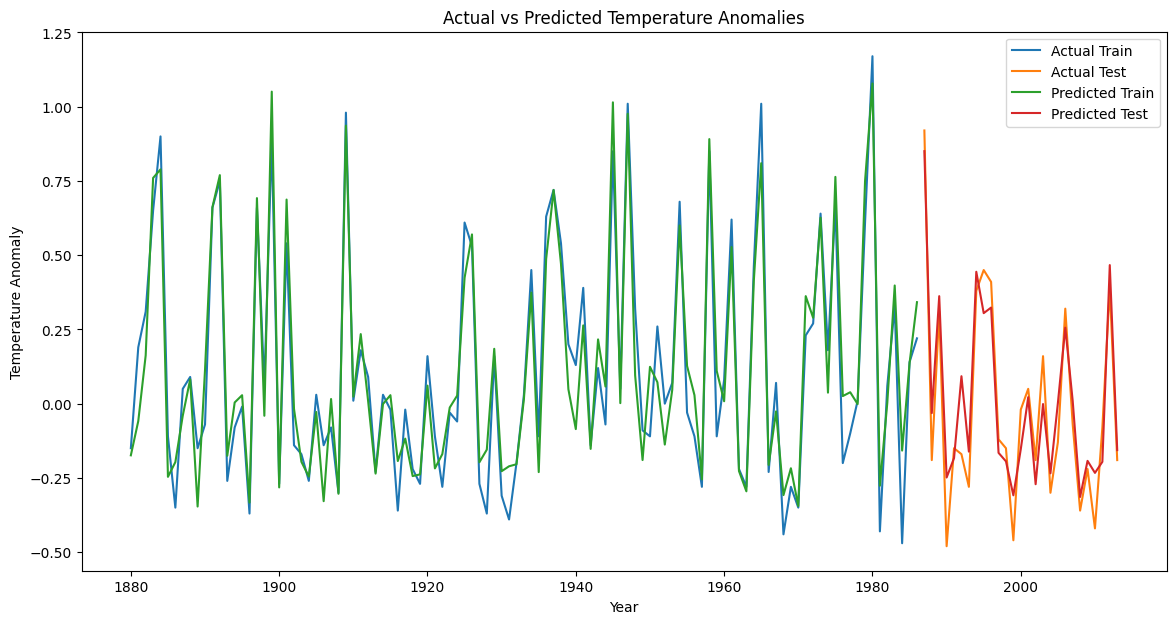

In [5]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_actual = scaler.inverse_transform([Y_train])
Y_test_actual = scaler.inverse_transform([Y_test])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(Y_train_actual[0])], Y_train_actual[0], label='Actual Train')
plt.plot(data.index[len(Y_train_actual[0]):len(Y_train_actual[0]) + len(Y_test_actual[0])], Y_test_actual[0], label='Actual Test')
plt.plot(data.index[:len(train_predict)], train_predict, label='Predicted Train')
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict, label='Predicted Test')
plt.title('Actual vs Predicted Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.show()


1/1 [==============================] - 0s 22ms/step


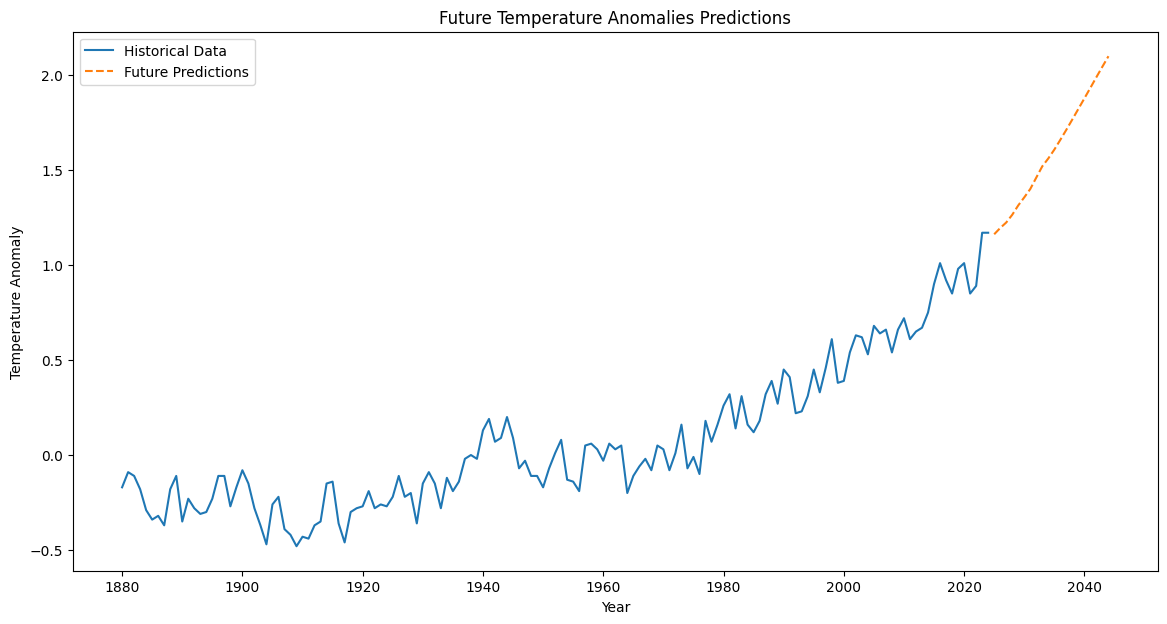

In [7]:
# Future predictions
future_steps = 20
last_data = data_array[-time_step:]

future_predict = []
current_input = last_data

for _ in range(future_steps):
    current_input = current_input.reshape((1, time_step, 1))
    prediction = model.predict(current_input)
    future_predict.append(prediction[0, 0])
    current_input = np.append(current_input[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform future predictions
future_predict = scaler.inverse_transform([future_predict])[0]

# Plot future predictions
future_years = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='YS')[1:]

plt.figure(figsize=(14, 7))
plt.plot(data.index, scaler.inverse_transform(data), label='Historical Data')
plt.plot(future_years, future_predict, label='Future Predictions', linestyle='dashed')
plt.title('Future Temperature Anomalies Predictions')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.show()



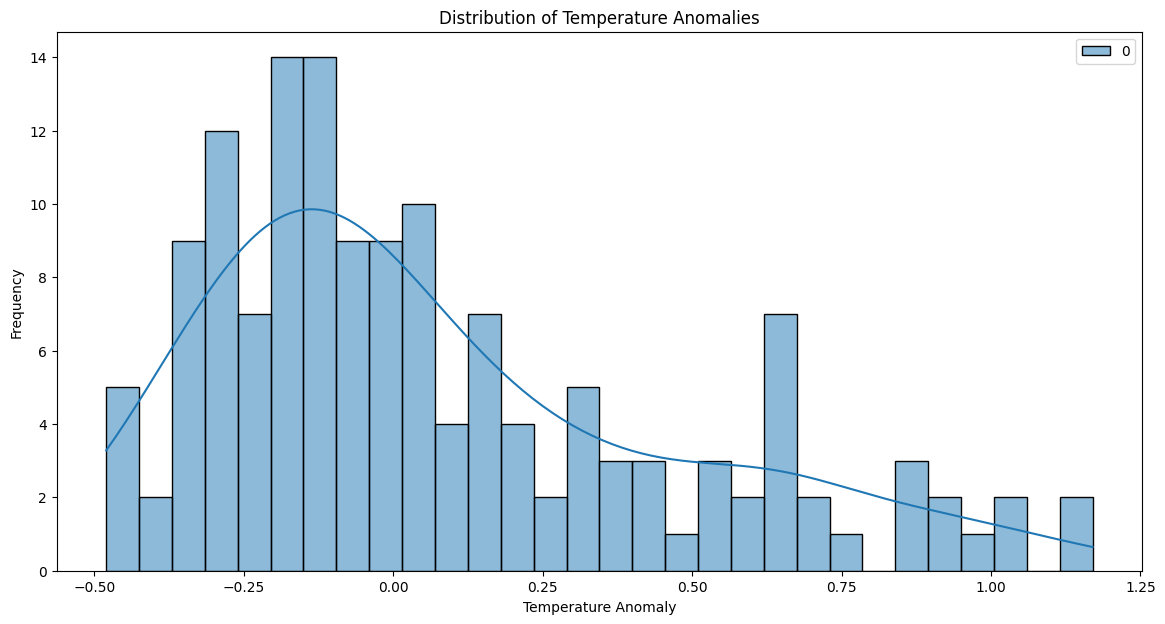

In [8]:
plt.figure(figsize=(14, 7))
sns.histplot(scaler.inverse_transform(data), bins=30, kde=True)
plt.title('Distribution of Temperature Anomalies')
plt.xlabel('Temperature Anomaly')
plt.ylabel('Frequency')
plt.show()


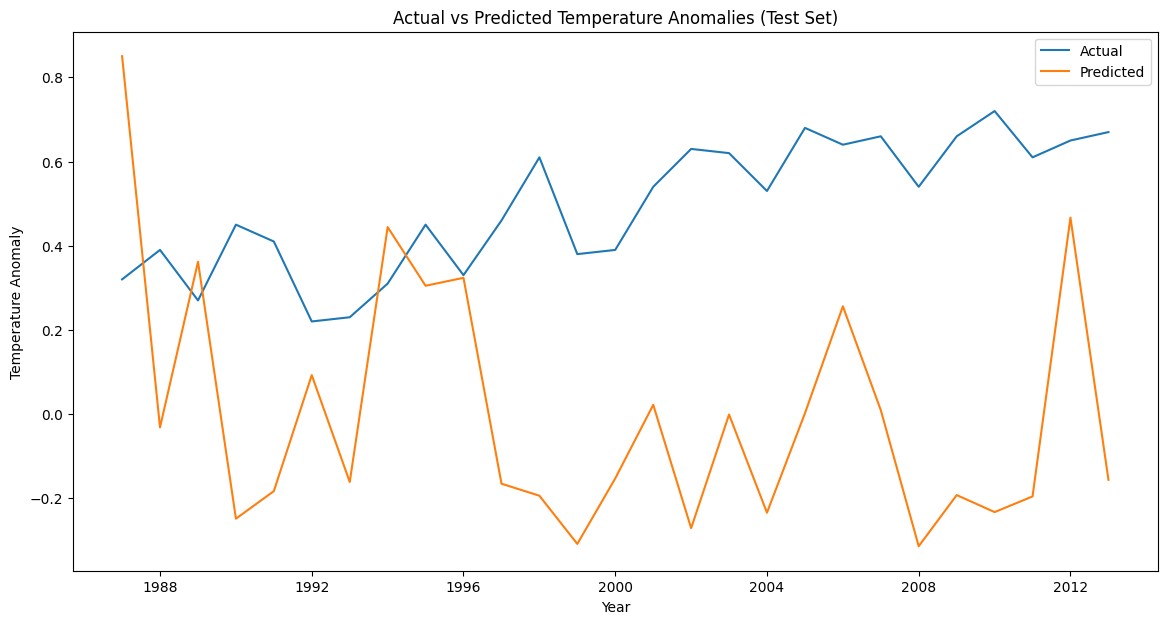

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], scaler.inverse_transform(data[len(train_predict):len(train_predict) + len(test_predict)]), label='Actual')
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict, label='Predicted')
plt.title('Actual vs Predicted Temperature Anomalies (Test Set)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.show()
